# At this point, remember to use pygraph environment

Long story...

# Load the final complete graph


In [1]:
import pickle
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import NeighborLoader
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import numpy as np
from tqdm import tqdm

In [2]:
def load_graph_checkpoint(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

# Load the final complete graph
print("Loading final complete graph...")
graph = load_graph_checkpoint('../7. GraphBuilding/final_complete_graph.pkl')
print("Graph loaded successfully!")
print(f"Nodes: {graph.number_of_nodes()}, Edges: {graph.number_of_edges()}")


Loading final complete graph...
Graph loaded successfully!
Nodes: 25610, Edges: 25728679


# Build the graphSAGE model


In [3]:
# Define the GraphSAGE model
class EfficientGraphSAGE(torch.nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_channels=256,
        out_channels=128,
        num_layers=2,
        dropout=0.2
    ):
        super().__init__()
        self.num_layers = num_layers
        
        # Input layer
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels, aggr='mean'))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels, aggr='mean'))
        
        # Output layer
        self.convs.append(SAGEConv(hidden_channels, out_channels, aggr='mean'))
        
        self.dropout = torch.nn.Dropout(dropout)
        self.batch_norm = torch.nn.ModuleList([
            torch.nn.BatchNorm1d(hidden_channels) for _ in range(num_layers-1)
        ])
        self.batch_norm.append(torch.nn.BatchNorm1d(out_channels))

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = self.batch_norm[i](x)
            x = F.relu(x)
            x = self.dropout(x)
        x = self.convs[-1](x, edge_index)
        x = self.batch_norm[-1](x)
        return x
    
def prepare_graph_data(graph, device):
    """Convert NetworkX graph to PyG data"""
    print("Converting NetworkX graph to PyG format...")
    
    # Extract node features and edge index
    node_features = []
    
    # Get a sample node to check structure
    first_node = list(graph.nodes())[0]
    print("\nSample node data:")
    print(f"Title embedding type: {type(graph.nodes[first_node]['job_title_embedding'])}")
    print(f"Title embedding length: {len(graph.nodes[first_node]['job_title_embedding'])}")
    
    try:
        for node in tqdm(graph.nodes(), desc="Extracting node features"):
            features = []
            
            # Combine all embeddings
            features.extend(graph.nodes[node]['job_title_embedding'])
            features.extend(graph.nodes[node]['job_description_embedding'])
            features.extend(graph.nodes[node]['job_type_encoding'])
            node_features.append(features)
            
            # Print first node information
            if len(node_features) == 1:
                print(f"\nFeature dimensions for first node:")
                print(f"Title embedding: {len(graph.nodes[node]['job_title_embedding'])}")
                print(f"Description embedding: {len(graph.nodes[node]['job_description_embedding'])}")
                print(f"Job type encoding: {len(graph.nodes[node]['job_type_encoding'])}")
                print(f"Total features: {len(features)}")
    
    except Exception as e:
        print(f"\nError processing node features: {str(e)}")
        print("\nDetailed error information:")
        print(f"Node: {node}")
        print(f"Title embedding sample: {graph.nodes[node]['job_title_embedding'][:100]}")
        raise

    # Convert to tensors
    try:
        x = torch.tensor(np.array(node_features), dtype=torch.float)
        print(f"\nNode features tensor shape: {x.shape}")
    except Exception as e:
        print(f"\nError converting to tensor: {str(e)}")
        print(f"Node features list shape: {len(node_features)} x {len(node_features[0]) if node_features else 0}")
        raise
    
    # Create edge index and weights
    print("\nProcessing edges...")
    edge_index = []
    edge_weights = []
    
    try:
        for u, v, data in tqdm(graph.edges(data=True), desc="Processing edges"):
            u_idx = int(u.split('_')[1])
            v_idx = int(v.split('_')[1])
            edge_index.append([u_idx, v_idx])
            edge_weights.append(float(data.get('weight', 1.0)))
    except Exception as e:
        print(f"\nError processing edges: {str(e)}")
        print(f"Sample edge: {u} -> {v}")
        print(f"Edge data: {data}")
        raise

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_weights = torch.tensor(edge_weights, dtype=torch.float)
    
    # Create PyG data object
    data = Data(
        x=x,
        edge_index=edge_index,
        edge_weight=edge_weights,
        num_nodes=len(graph)
    )
    
    print("\nData preparation completed successfully!")
    print(f"Features shape: {data.x.shape}")
    print(f"Edge index shape: {data.edge_index.shape}")
    print(f"Edge weights shape: {data.edge_weight.shape}")
    
    return data.to(device)

Using device: cuda
Initial GPU memory: 0.62 GB
Attempting to load cached graph data...


C:\Users\Brandon\AppData\Local\Temp\ipykernel_13096\2586903041.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(cached_data_path)
C:\Users\Brandon\AppD

Successfully loaded cached graph data!
Initializing model...
No checkpoint found, starting fresh training
GPU memory after data loading: 0.63 GB
Starting training from epoch 1 to 150...


Epoch 1/150:   0%|          | 0/51 [00:00<?, ?it/s]C:\Users\Brandon\AppData\Local\Temp\ipykernel_13096\2586903041.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/150: 100%|██████████| 51/51 [00:04<00:00, 12.27it/s, loss=0.17] 


Epoch 1, Average Loss: 0.3316
Saved new best model with loss: 0.3316


Epoch 2/150: 100%|██████████| 51/51 [00:03<00:00, 13.52it/s, loss=0.143] 


Epoch 2, Average Loss: 0.1126
Saved new best model with loss: 0.1126


Epoch 3/150: 100%|██████████| 51/51 [00:03<00:00, 13.48it/s, loss=0.134] 


Epoch 3, Average Loss: 0.1026
Saved new best model with loss: 0.1026


Epoch 4/150: 100%|██████████| 51/51 [00:03<00:00, 13.45it/s, loss=0.118] 


Epoch 4, Average Loss: 0.0948
Saved new best model with loss: 0.0948


Epoch 5/150: 100%|██████████| 51/51 [00:03<00:00, 13.47it/s, loss=0.11]  


Epoch 5, Average Loss: 0.0880
Saved new best model with loss: 0.0880


Epoch 6/150: 100%|██████████| 51/51 [00:03<00:00, 13.40it/s, loss=0.12]  


Epoch 6, Average Loss: 0.0806
Saved new best model with loss: 0.0806


Epoch 7/150: 100%|██████████| 51/51 [00:03<00:00, 13.50it/s, loss=0.0935]


Epoch 7, Average Loss: 0.0743
Saved new best model with loss: 0.0743


Epoch 8/150: 100%|██████████| 51/51 [00:03<00:00, 13.31it/s, loss=0.0985]


Epoch 8, Average Loss: 0.0676
Saved new best model with loss: 0.0676


Epoch 9/150: 100%|██████████| 51/51 [00:03<00:00, 13.35it/s, loss=0.0936]


Epoch 9, Average Loss: 0.0620
Saved new best model with loss: 0.0620


Epoch 10/150: 100%|██████████| 51/51 [00:03<00:00, 13.34it/s, loss=0.0685]


Epoch 10, Average Loss: 0.0561
Saved new best model with loss: 0.0561


Epoch 11/150: 100%|██████████| 51/51 [00:03<00:00, 13.38it/s, loss=0.0641]


Epoch 11, Average Loss: 0.0515
Saved new best model with loss: 0.0515


Epoch 12/150: 100%|██████████| 51/51 [00:03<00:00, 13.52it/s, loss=0.0576]


Epoch 12, Average Loss: 0.0460
Saved new best model with loss: 0.0460


Epoch 13/150: 100%|██████████| 51/51 [00:03<00:00, 13.45it/s, loss=0.0518]


Epoch 13, Average Loss: 0.0416
Saved new best model with loss: 0.0416


Epoch 14/150: 100%|██████████| 51/51 [00:03<00:00, 13.46it/s, loss=0.04]  


Epoch 14, Average Loss: 0.0369
Saved new best model with loss: 0.0369


Epoch 15/150: 100%|██████████| 51/51 [00:03<00:00, 13.56it/s, loss=0.038] 


Epoch 15, Average Loss: 0.0326
Saved new best model with loss: 0.0326


Epoch 16/150: 100%|██████████| 51/51 [00:03<00:00, 13.52it/s, loss=0.0313]


Epoch 16, Average Loss: 0.0285
Saved new best model with loss: 0.0285


Epoch 17/150: 100%|██████████| 51/51 [00:03<00:00, 13.55it/s, loss=0.0276]


Epoch 17, Average Loss: 0.0246
Saved new best model with loss: 0.0246


Epoch 18/150: 100%|██████████| 51/51 [00:03<00:00, 13.57it/s, loss=0.0253]


Epoch 18, Average Loss: 0.0210
Saved new best model with loss: 0.0210


Epoch 19/150: 100%|██████████| 51/51 [00:03<00:00, 13.49it/s, loss=0.0183]


Epoch 19, Average Loss: 0.0173
Saved new best model with loss: 0.0173


Epoch 20/150: 100%|██████████| 51/51 [00:03<00:00, 13.62it/s, loss=0.014] 


Epoch 20, Average Loss: 0.0140
Saved new best model with loss: 0.0140


Epoch 21/150: 100%|██████████| 51/51 [00:03<00:00, 13.60it/s, loss=0.00941]


Epoch 21, Average Loss: 0.0108
Saved new best model with loss: 0.0108


Epoch 22/150: 100%|██████████| 51/51 [00:03<00:00, 13.58it/s, loss=0.00756]


Epoch 22, Average Loss: 0.0084
Saved new best model with loss: 0.0084


Epoch 23/150: 100%|██████████| 51/51 [00:03<00:00, 13.64it/s, loss=0.00619]


Epoch 23, Average Loss: 0.0069
Saved new best model with loss: 0.0069


Epoch 24/150: 100%|██████████| 51/51 [00:03<00:00, 13.62it/s, loss=0.00481]


Epoch 24, Average Loss: 0.0055
Saved new best model with loss: 0.0055


Epoch 25/150: 100%|██████████| 51/51 [00:03<00:00, 13.49it/s, loss=0.00349]


Epoch 25, Average Loss: 0.0041
Saved new best model with loss: 0.0041


Epoch 26/150: 100%|██████████| 51/51 [00:03<00:00, 13.53it/s, loss=0.00221]


Epoch 26, Average Loss: 0.0028
Saved new best model with loss: 0.0028


Epoch 27/150: 100%|██████████| 51/51 [00:03<00:00, 13.59it/s, loss=0.00101]


Epoch 27, Average Loss: 0.0015
Saved new best model with loss: 0.0015


Epoch 28/150: 100%|██████████| 51/51 [00:03<00:00, 13.59it/s, loss=0.000558]


Epoch 28, Average Loss: 0.0007
Saved new best model with loss: 0.0007


Epoch 29/150: 100%|██████████| 51/51 [00:03<00:00, 13.60it/s, loss=0.00054] 


Epoch 29, Average Loss: 0.0005
Saved new best model with loss: 0.0005


Epoch 30/150: 100%|██████████| 51/51 [00:03<00:00, 13.50it/s, loss=0.00055] 


Epoch 30, Average Loss: 0.0005


Epoch 31/150: 100%|██████████| 51/51 [00:03<00:00, 13.57it/s, loss=0.00052] 


Epoch 31, Average Loss: 0.0005
Saved new best model with loss: 0.0005


Epoch 32/150: 100%|██████████| 51/51 [00:03<00:00, 13.56it/s, loss=0.000538]


Epoch 32, Average Loss: 0.0005


Epoch 33/150: 100%|██████████| 51/51 [00:03<00:00, 13.66it/s, loss=0.000535]


Epoch 33, Average Loss: 0.0005
Saved new best model with loss: 0.0005


Epoch 34/150: 100%|██████████| 51/51 [00:03<00:00, 13.67it/s, loss=0.000532]


Epoch 34, Average Loss: 0.0005
Saved new best model with loss: 0.0005


Epoch 35/150: 100%|██████████| 51/51 [00:03<00:00, 13.60it/s, loss=0.000514]


Epoch 35, Average Loss: 0.0005
Saved new best model with loss: 0.0005


Epoch 36/150: 100%|██████████| 51/51 [00:03<00:00, 13.64it/s, loss=0.000509]


Epoch 36, Average Loss: 0.0005
Saved new best model with loss: 0.0005


Epoch 37/150: 100%|██████████| 51/51 [00:03<00:00, 13.63it/s, loss=0.000541]


Epoch 37, Average Loss: 0.0005
Saved new best model with loss: 0.0005


Epoch 38/150: 100%|██████████| 51/51 [00:03<00:00, 13.54it/s, loss=0.000504]


Epoch 38, Average Loss: 0.0005


Epoch 39/150: 100%|██████████| 51/51 [00:03<00:00, 13.63it/s, loss=0.000466]


Epoch 39, Average Loss: 0.0005


Epoch 40/150: 100%|██████████| 51/51 [00:03<00:00, 13.54it/s, loss=0.000545]


Epoch 40, Average Loss: 0.0005


Epoch 41/150: 100%|██████████| 51/51 [00:03<00:00, 13.24it/s, loss=0.000501]


Epoch 41, Average Loss: 0.0005


Epoch 42/150: 100%|██████████| 51/51 [00:03<00:00, 13.32it/s, loss=0.000536]


Epoch 42, Average Loss: 0.0005


Epoch 43/150: 100%|██████████| 51/51 [00:03<00:00, 13.30it/s, loss=0.000552]


Epoch 43, Average Loss: 0.0005


Epoch 44/150: 100%|██████████| 51/51 [00:03<00:00, 13.25it/s, loss=0.000454]


Epoch 44, Average Loss: 0.0005
Saved new best model with loss: 0.0005


Epoch 45/150: 100%|██████████| 51/51 [00:03<00:00, 13.36it/s, loss=0.000491]


Epoch 45, Average Loss: 0.0005
Saved new best model with loss: 0.0005


Epoch 46/150: 100%|██████████| 51/51 [00:03<00:00, 13.22it/s, loss=0.000452]


Epoch 46, Average Loss: 0.0005
Saved new best model with loss: 0.0005


Epoch 47/150: 100%|██████████| 51/51 [00:03<00:00, 13.22it/s, loss=0.000445]


Epoch 47, Average Loss: 0.0005


Epoch 48/150: 100%|██████████| 51/51 [00:03<00:00, 13.02it/s, loss=0.000478]


Epoch 48, Average Loss: 0.0005


Epoch 49/150: 100%|██████████| 51/51 [00:03<00:00, 13.28it/s, loss=0.000473]


Epoch 49, Average Loss: 0.0005
Saved new best model with loss: 0.0005


Epoch 50/150: 100%|██████████| 51/51 [00:03<00:00, 13.29it/s, loss=0.000436]


Epoch 50, Average Loss: 0.0005


Epoch 51/150: 100%|██████████| 51/51 [00:03<00:00, 13.36it/s, loss=0.000483]


Epoch 51, Average Loss: 0.0005
Saved new best model with loss: 0.0005


Epoch 52/150: 100%|██████████| 51/51 [00:03<00:00, 13.14it/s, loss=0.000471]


Epoch 52, Average Loss: 0.0005


Epoch 53/150: 100%|██████████| 51/51 [00:03<00:00, 13.23it/s, loss=0.000452]


Epoch 53, Average Loss: 0.0005


Epoch 54/150: 100%|██████████| 51/51 [00:03<00:00, 13.15it/s, loss=0.000477]


Epoch 54, Average Loss: 0.0005


Epoch 55/150: 100%|██████████| 51/51 [00:03<00:00, 13.28it/s, loss=0.000478]


Epoch 55, Average Loss: 0.0005


Epoch 56/150: 100%|██████████| 51/51 [00:03<00:00, 13.36it/s, loss=0.000445]


Epoch 56, Average Loss: 0.0005


Epoch 57/150: 100%|██████████| 51/51 [00:03<00:00, 13.40it/s, loss=0.000458]


Epoch 57, Average Loss: 0.0005


Epoch 58/150: 100%|██████████| 51/51 [00:03<00:00, 13.32it/s, loss=0.000427]


Epoch 58, Average Loss: 0.0005
Saved new best model with loss: 0.0005


Epoch 59/150: 100%|██████████| 51/51 [00:03<00:00, 13.31it/s, loss=0.00049] 


Epoch 59, Average Loss: 0.0005


Epoch 60/150: 100%|██████████| 51/51 [00:03<00:00, 13.37it/s, loss=0.000465]


Epoch 60, Average Loss: 0.0005


Epoch 61/150: 100%|██████████| 51/51 [00:03<00:00, 13.38it/s, loss=0.000461]


Epoch 61, Average Loss: 0.0005


Epoch 62/150: 100%|██████████| 51/51 [00:03<00:00, 13.39it/s, loss=0.000472]


Epoch 62, Average Loss: 0.0005


Epoch 63/150: 100%|██████████| 51/51 [00:03<00:00, 13.53it/s, loss=0.000487]


Epoch 63, Average Loss: 0.0005


Epoch 64/150: 100%|██████████| 51/51 [00:03<00:00, 13.52it/s, loss=0.000479]


Epoch 64, Average Loss: 0.0005
Saved new best model with loss: 0.0005


Epoch 65/150: 100%|██████████| 51/51 [00:03<00:00, 13.35it/s, loss=0.000459]


Epoch 65, Average Loss: 0.0005


Epoch 66/150: 100%|██████████| 51/51 [00:03<00:00, 13.46it/s, loss=0.000442]


Epoch 66, Average Loss: 0.0005


Epoch 67/150: 100%|██████████| 51/51 [00:03<00:00, 13.47it/s, loss=0.000475]


Epoch 67, Average Loss: 0.0005


Epoch 68/150: 100%|██████████| 51/51 [00:03<00:00, 13.44it/s, loss=0.000429]


Epoch 68, Average Loss: 0.0005


Epoch 69/150: 100%|██████████| 51/51 [00:03<00:00, 13.50it/s, loss=0.000446]


Epoch 69, Average Loss: 0.0005


Epoch 70/150: 100%|██████████| 51/51 [00:03<00:00, 13.48it/s, loss=0.000466]


Epoch 70, Average Loss: 0.0005


Epoch 71/150: 100%|██████████| 51/51 [00:03<00:00, 13.41it/s, loss=0.000421]


Epoch 71, Average Loss: 0.0004
Saved new best model with loss: 0.0004


Epoch 72/150: 100%|██████████| 51/51 [00:03<00:00, 13.55it/s, loss=0.000474]


Epoch 72, Average Loss: 0.0004


Epoch 73/150: 100%|██████████| 51/51 [00:03<00:00, 13.51it/s, loss=0.000441]


Epoch 73, Average Loss: 0.0004


Epoch 74/150: 100%|██████████| 51/51 [00:03<00:00, 13.49it/s, loss=0.000457]


Epoch 74, Average Loss: 0.0004


Epoch 75/150: 100%|██████████| 51/51 [00:03<00:00, 13.52it/s, loss=0.000473]


Epoch 75, Average Loss: 0.0004
Saved new best model with loss: 0.0004


Epoch 76/150: 100%|██████████| 51/51 [00:03<00:00, 13.54it/s, loss=0.000464]


Epoch 76, Average Loss: 0.0004
Saved new best model with loss: 0.0004


Epoch 77/150: 100%|██████████| 51/51 [00:03<00:00, 13.48it/s, loss=0.000425]


Epoch 77, Average Loss: 0.0004


Epoch 78/150: 100%|██████████| 51/51 [00:03<00:00, 13.55it/s, loss=0.000434]


Epoch 78, Average Loss: 0.0004
Saved new best model with loss: 0.0004


Epoch 79/150: 100%|██████████| 51/51 [00:03<00:00, 13.32it/s, loss=0.000448]


Epoch 79, Average Loss: 0.0004


Epoch 80/150: 100%|██████████| 51/51 [00:03<00:00, 13.59it/s, loss=0.000435]


Epoch 80, Average Loss: 0.0004


Epoch 81/150: 100%|██████████| 51/51 [00:03<00:00, 13.22it/s, loss=0.000443]


Epoch 81, Average Loss: 0.0004


Epoch 82/150: 100%|██████████| 51/51 [00:03<00:00, 13.60it/s, loss=0.000456]


Epoch 82, Average Loss: 0.0004


Epoch 83/150: 100%|██████████| 51/51 [00:03<00:00, 13.65it/s, loss=0.000458]


Epoch 83, Average Loss: 0.0004


Epoch 84/150: 100%|██████████| 51/51 [00:03<00:00, 13.60it/s, loss=0.00044] 


Epoch 84, Average Loss: 0.0004


Epoch 85/150: 100%|██████████| 51/51 [00:03<00:00, 13.73it/s, loss=0.00045] 


Epoch 85, Average Loss: 0.0004
Saved new best model with loss: 0.0004


Epoch 86/150: 100%|██████████| 51/51 [00:03<00:00, 13.65it/s, loss=0.000456]


Epoch 86, Average Loss: 0.0004


Epoch 87/150: 100%|██████████| 51/51 [00:03<00:00, 13.61it/s, loss=0.000424]


Epoch 87, Average Loss: 0.0004


Epoch 88/150: 100%|██████████| 51/51 [00:03<00:00, 13.65it/s, loss=0.000441]


Epoch 88, Average Loss: 0.0004
Saved new best model with loss: 0.0004


Epoch 89/150: 100%|██████████| 51/51 [00:03<00:00, 13.59it/s, loss=0.000402]


Epoch 89, Average Loss: 0.0004
Saved new best model with loss: 0.0004


Epoch 90/150: 100%|██████████| 51/51 [00:03<00:00, 13.77it/s, loss=0.000456]


Epoch 90, Average Loss: 0.0004


Epoch 91/150: 100%|██████████| 51/51 [00:03<00:00, 13.60it/s, loss=0.000459]


Epoch 91, Average Loss: 0.0004
Saved new best model with loss: 0.0004


Epoch 92/150: 100%|██████████| 51/51 [00:03<00:00, 13.66it/s, loss=0.000406]


Epoch 92, Average Loss: 0.0004


Epoch 93/150: 100%|██████████| 51/51 [00:03<00:00, 13.69it/s, loss=0.000438]


Epoch 93, Average Loss: 0.0004
Saved new best model with loss: 0.0004


Epoch 94/150: 100%|██████████| 51/51 [00:03<00:00, 13.65it/s, loss=0.000429]


Epoch 94, Average Loss: 0.0004


Epoch 95/150: 100%|██████████| 51/51 [00:03<00:00, 13.59it/s, loss=0.000429]


Epoch 95, Average Loss: 0.0004


Epoch 96/150: 100%|██████████| 51/51 [00:03<00:00, 13.64it/s, loss=0.000434]


Epoch 96, Average Loss: 0.0004


Epoch 97/150: 100%|██████████| 51/51 [00:03<00:00, 13.71it/s, loss=0.000382]


Epoch 97, Average Loss: 0.0004


Epoch 98/150: 100%|██████████| 51/51 [00:03<00:00, 13.51it/s, loss=0.000436]


Epoch 98, Average Loss: 0.0004


Epoch 99/150: 100%|██████████| 51/51 [00:03<00:00, 13.68it/s, loss=0.000423]


Epoch 99, Average Loss: 0.0004


Epoch 100/150: 100%|██████████| 51/51 [00:03<00:00, 13.62it/s, loss=0.000468]


Epoch 100, Average Loss: 0.0004


Epoch 101/150: 100%|██████████| 51/51 [00:03<00:00, 13.67it/s, loss=0.000441]


Epoch 101, Average Loss: 0.0004


Epoch 102/150: 100%|██████████| 51/51 [00:03<00:00, 13.53it/s, loss=0.000459]


Epoch 102, Average Loss: 0.0004


Epoch 103/150: 100%|██████████| 51/51 [00:03<00:00, 13.67it/s, loss=0.000432]


Epoch 103, Average Loss: 0.0004
Saved new best model with loss: 0.0004


Epoch 104/150: 100%|██████████| 51/51 [00:03<00:00, 13.55it/s, loss=0.000458]


Epoch 104, Average Loss: 0.0004


Epoch 105/150: 100%|██████████| 51/51 [00:03<00:00, 13.57it/s, loss=0.000452]


Epoch 105, Average Loss: 0.0004


Epoch 106/150: 100%|██████████| 51/51 [00:03<00:00, 13.66it/s, loss=0.000451]


Epoch 106, Average Loss: 0.0004


Epoch 107/150: 100%|██████████| 51/51 [00:03<00:00, 13.49it/s, loss=0.000416]


Epoch 107, Average Loss: 0.0004


Epoch 108/150: 100%|██████████| 51/51 [00:03<00:00, 13.60it/s, loss=0.000423]


Epoch 108, Average Loss: 0.0004


Epoch 109/150: 100%|██████████| 51/51 [00:03<00:00, 13.64it/s, loss=0.000464]


Epoch 109, Average Loss: 0.0004
Saved new best model with loss: 0.0004


Epoch 110/150: 100%|██████████| 51/51 [00:03<00:00, 13.61it/s, loss=0.00041] 


Epoch 110, Average Loss: 0.0004


Epoch 111/150: 100%|██████████| 51/51 [00:03<00:00, 13.45it/s, loss=0.000479]


Epoch 111, Average Loss: 0.0004


Epoch 112/150: 100%|██████████| 51/51 [00:03<00:00, 13.65it/s, loss=0.000428]


Epoch 112, Average Loss: 0.0004


Epoch 113/150: 100%|██████████| 51/51 [00:03<00:00, 13.74it/s, loss=0.000437]


Epoch 113, Average Loss: 0.0004


Epoch 114/150: 100%|██████████| 51/51 [00:03<00:00, 13.69it/s, loss=0.000451]


Epoch 114, Average Loss: 0.0004


Epoch 115/150: 100%|██████████| 51/51 [00:03<00:00, 13.67it/s, loss=0.000428]


Epoch 115, Average Loss: 0.0004


Epoch 116/150: 100%|██████████| 51/51 [00:03<00:00, 13.67it/s, loss=0.000461]


Epoch 116, Average Loss: 0.0004


Epoch 117/150: 100%|██████████| 51/51 [00:03<00:00, 13.69it/s, loss=0.000429]


Epoch 117, Average Loss: 0.0004


Epoch 118/150: 100%|██████████| 51/51 [00:03<00:00, 13.66it/s, loss=0.000444]


Epoch 118, Average Loss: 0.0004


Epoch 119/150: 100%|██████████| 51/51 [00:03<00:00, 13.72it/s, loss=0.000426]


Epoch 119, Average Loss: 0.0004
Early stopping triggered!
Training completed!


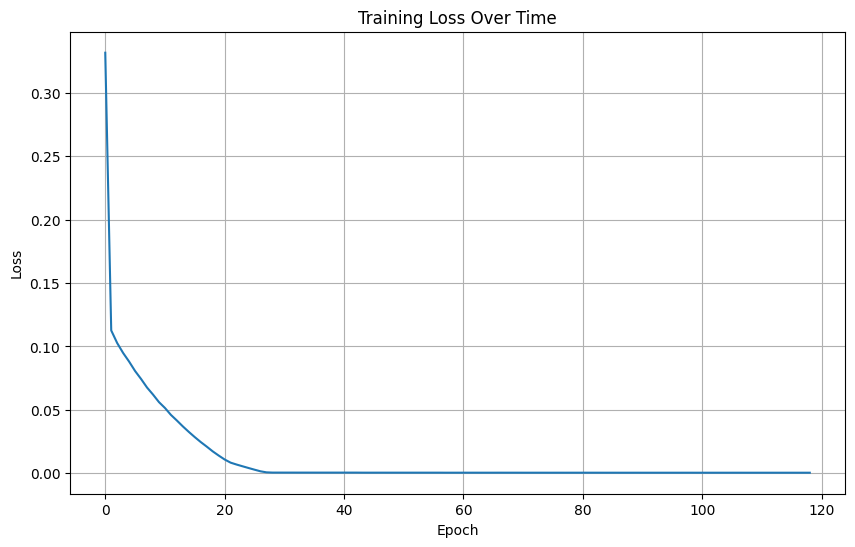

In [5]:
# Set up GPU device and print memory info
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"Initial GPU memory: {torch.cuda.memory_allocated()/1e9:.2f} GB")

# Try to load cached data first
cached_data_path = 'gpu_processed_graph.pt'
try:
    print("Attempting to load cached graph data...")
    data = torch.load(cached_data_path)
    data = data.to(device)
    print("Successfully loaded cached graph data!")
except FileNotFoundError:
    print("No cached data found. Processing graph from scratch...")
    # Prepare the data
    data = prepare_graph_data(graph, device)
    # Cache the processed data
    print("Caching processed graph data...")
    torch.save(data, cached_data_path)
    print("Graph data cached successfully!")

in_channels = data.x.size(1)

# Initialize model
print("Initializing model...")
model = EfficientGraphSAGE(
    in_channels=in_channels,
    hidden_channels=512,  # Increased to help with dimensionality reduction
    out_channels=384,    # Changed to desired embedding size
    num_layers=3,        # Added an extra layer to help with dimensionality reduction
    dropout=0.2
).to(device)

# Set up optimizer with different learning rates for different components
optimizer = torch.optim.AdamW([
    {'params': model.convs.parameters(), 'lr': 0.001},
    {'params': model.batch_norm.parameters(), 'lr': 0.001}
])

# Try to load checkpoint if it exists
start_epoch = 0
training_losses = []  # Store losses for plotting
try:
    checkpoint = torch.load('best_graphsage_model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_loss = checkpoint['loss']
    if 'training_losses' in checkpoint:
        training_losses = checkpoint['training_losses']
    print(f"Loaded checkpoint from epoch {start_epoch-1} with loss {best_loss:.4f}")
except FileNotFoundError:
    print("No checkpoint found, starting fresh training")
    best_loss = float('inf')

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Process data in smaller chunks if needed
batch_size = 512  # Smaller batch size for memory efficiency
train_loader = NeighborLoader(
    data,
    num_neighbors=[10, 5],  # Reduced number of neighbors
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)

# Print memory usage after data loading
if torch.cuda.is_available():
    print(f"GPU memory after data loading: {torch.cuda.memory_allocated()/1e9:.2f} GB")

num_epochs = 150
patience = 10
patience_counter = 0

# Enable automatic mixed precision for faster training
scaler = torch.cuda.amp.GradScaler()

print(f"Starting training from epoch {start_epoch+1} to {num_epochs}...")
for epoch in range(start_epoch, num_epochs):
    model.train()
    total_loss = 0
    num_batches = 0
    
    # Process batches with progress bar
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for batch in pbar:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Use automatic mixed precision
        with torch.cuda.amp.autocast():
            # Forward pass
            out = model(batch.x, batch.edge_index)[:batch.batch_size]  # Only take batch_size nodes
            
            # Project target to same dimension as output
            target = batch.x[:batch.batch_size]
            target_projected = torch.nn.Linear(target.shape[1], 384).to(device)(target)
            
            loss = F.mse_loss(out, target_projected)
            
            # Add L2 regularization
            l2_reg = 0
            for param in model.parameters():
                l2_reg += torch.norm(param)
            loss += 0.001 * l2_reg
        
        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        
        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        num_batches += 1
        
        # Update progress bar
        pbar.set_postfix({'loss': loss.item()})
    
    # Compute average loss
    avg_loss = total_loss / num_batches
    training_losses.append(avg_loss)
    print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')
    
    # Learning rate scheduling
    scheduler.step(avg_loss)
    
    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
            'training_losses': training_losses
        }, 'best_graphsage_model.pt')
        print(f"Saved new best model with loss: {best_loss:.4f}")
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print("Early stopping triggered!")
        break

print("Training completed!")

# Plot training loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(len(training_losses)), training_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Generate the embeddings from the model

In [6]:
import pickle
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import NeighborLoader
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import numpy as np
from tqdm import tqdm

In [7]:
# Define the GraphSAGE model
class EfficientGraphSAGE(torch.nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_channels=256,
        out_channels=128,
        num_layers=2,
        dropout=0.2
    ):
        super().__init__()
        self.num_layers = num_layers
        
        # Input layer
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels, aggr='mean'))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels, aggr='mean'))
        
        # Output layer
        self.convs.append(SAGEConv(hidden_channels, out_channels, aggr='mean'))
        
        self.dropout = torch.nn.Dropout(dropout)
        self.batch_norm = torch.nn.ModuleList([
            torch.nn.BatchNorm1d(hidden_channels) for _ in range(num_layers-1)
        ])
        self.batch_norm.append(torch.nn.BatchNorm1d(out_channels))

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            x = self.batch_norm[i](x)
            x = F.relu(x)
            x = self.dropout(x)
        x = self.convs[-1](x, edge_index)
        x = self.batch_norm[-1](x)
        return x
    
def prepare_graph_data(graph, device):
    """Convert NetworkX graph to PyG data"""
    print("Converting NetworkX graph to PyG format...")
    
    # Extract node features and edge index
    node_features = []
    
    # Get a sample node to check structure
    first_node = list(graph.nodes())[0]
    print("\nSample node data:")
    print(f"Title embedding type: {type(graph.nodes[first_node]['job_title_embedding'])}")
    print(f"Title embedding length: {len(graph.nodes[first_node]['job_title_embedding'])}")
    
    try:
        for node in tqdm(graph.nodes(), desc="Extracting node features"):
            features = []
            
            # Get numpy arrays directly
            title_emb = graph.nodes[node]['job_title_embedding']
            desc_emb = graph.nodes[node]['job_description_embedding']
            type_emb = graph.nodes[node]['job_type_encoding']
            
            # Combine all embeddings
            features.extend(title_emb)
            features.extend(desc_emb)
            features.extend(type_emb)
            node_features.append(features)
            
            # Print first node information
            if len(node_features) == 1:
                print(f"\nFeature dimensions for first node:")
                print(f"Title embedding: {len(title_emb)}")
                print(f"Description embedding: {len(desc_emb)}")
                print(f"Job type encoding: {len(type_emb)}")
                print(f"Total features: {len(features)}")
    
    except Exception as e:
        print(f"\nError processing node features: {str(e)}")
        print("\nDetailed error information:")
        print(f"Node: {node}")
        print(f"Title embedding sample: {graph.nodes[node]['job_title_embedding'][:100]}")
        raise

    # Convert to tensors
    try:
        x = torch.tensor(np.array(node_features), dtype=torch.float)
        print(f"\nNode features tensor shape: {x.shape}")
    except Exception as e:
        print(f"\nError converting to tensor: {str(e)}")
        print(f"Node features list shape: {len(node_features)} x {len(node_features[0]) if node_features else 0}")
        raise
    
    # Create edge index and weights
    print("\nProcessing edges...")
    edge_index = []
    edge_weights = []
    
    try:
        for u, v, data in tqdm(graph.edges(data=True), desc="Processing edges"):
            u_idx = int(u.split('_')[1])
            v_idx = int(v.split('_')[1])
            edge_index.append([u_idx, v_idx])
            edge_weights.append(float(data.get('weight', 1.0)))
    except Exception as e:
        print(f"\nError processing edges: {str(e)}")
        print(f"Sample edge: {u} -> {v}")
        print(f"Edge data: {data}")
        raise

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_weights = torch.tensor(edge_weights, dtype=torch.float)
    
    # Create PyG data object
    data = Data(
        x=x,
        edge_index=edge_index,
        edge_weight=edge_weights,
        num_nodes=len(graph)
    )
    
    print("\nData preparation completed successfully!")
    print(f"Features shape: {data.x.shape}")
    print(f"Edge index shape: {data.edge_index.shape}")
    print(f"Edge weights shape: {data.edge_weight.shape}")
    
    return data.to(device)

In [8]:
# Set up GPU device and print memory info
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"Initial GPU memory: {torch.cuda.memory_allocated()/1e9:.2f} GB")

# Try to load cached data first
cached_data_path = 'gpu_processed_graph.pt'
try:
    print("Attempting to load cached graph data...")
    data = torch.load(cached_data_path)
    data = data.to(device)
    print("Successfully loaded cached graph data!")
except FileNotFoundError:
    print("No cached data found. Processing graph from scratch...")
    # Prepare the data
    data = prepare_graph_data(graph, device)
    # Cache the processed data
    print("Caching processed graph data...")
    torch.save(data, cached_data_path)
    print("Graph data cached successfully!")

in_channels = data.x.size(1)

# Initialize model
print("Initializing model...")
model = EfficientGraphSAGE(
    in_channels=in_channels,
    hidden_channels=512,  # Increased to help with dimensionality reduction
    out_channels=384,    # Changed to desired embedding size
    num_layers=3,        # Added an extra layer to help with dimensionality reduction
    dropout=0.2
).to(device)

Using device: cuda
Initial GPU memory: 0.67 GB
Attempting to load cached graph data...
Successfully loaded cached graph data!
Initializing model...


C:\Users\Brandon\AppData\Local\Temp\ipykernel_13096\2110895155.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(cached_data_path)


In [9]:
# Set CUDA launch blocking for better error tracking
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load the best model and generate embeddings
print("Loading best model...")
checkpoint = torch.load('best_graphsage_model.pt', weights_only=True)  # Set weights_only=True
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

def generate_embeddings(model, data, batch_size=64):  # Reduced batch size to 64
    """Generate embeddings for all nodes"""
    print("Generating embeddings...")
    embeddings = []
    model.eval()
    
    # Get list of all edges and keep on CPU
    edge_index = data.edge_index.cpu()
    data.x = data.x.cpu()  # Move features to CPU
    
    with torch.no_grad():
        for i in tqdm(range(0, data.num_nodes, batch_size)):
            batch_end = min(i + batch_size, data.num_nodes)
            batch_nodes = list(range(i, batch_end))
            
            # Process edge mask on CPU
            mask = (edge_index[0].unsqueeze(1) == torch.tensor(batch_nodes)).any(dim=1) | \
                   (edge_index[1].unsqueeze(1) == torch.tensor(batch_nodes)).any(dim=1)
            
            # Only move necessary data to GPU
            batch_edge_index = edge_index[:, mask].to(device)
            batch_x = data.x.to(device)  # Move all node features to GPU
            
            try:
                # Verify indices are in valid range
                max_index = batch_edge_index.max().item()
                if max_index >= batch_x.size(0):
                    print(f"Invalid index found: {max_index} >= {batch_x.size(0)}")
                    continue
                    
                # Generate embeddings for batch
                batch_emb = model(batch_x, batch_edge_index)
                embeddings.append(batch_emb[i:batch_end].cpu())  # Only keep embeddings for batch nodes
            except RuntimeError as e:
                print(f"Error with batch {i}-{batch_end}: {str(e)}")
                del batch_edge_index, batch_x
                torch.cuda.empty_cache()
                continue
                
            # Clear GPU memory
            del batch_edge_index, batch_x
            torch.cuda.empty_cache()
    
    # Concatenate all embeddings on CPU
    all_embeddings = torch.cat(embeddings, dim=0)
    print(f"Generated embeddings shape: {all_embeddings.shape}")
    return all_embeddings

# Generate and save embeddings
node_embeddings = generate_embeddings(model, data)
torch.save(node_embeddings, 'node_embeddings.pt')
print("Embeddings saved successfully!")

Loading best model...
Generating embeddings...


100%|██████████| 401/401 [03:18<00:00,  2.02it/s]


Generated embeddings shape: torch.Size([25610, 384])
Embeddings saved successfully!
